# Selection of levels to perturb in LES runs

Yi-Ling's results show normalised responses in temperature and specific humidity, to perturbations of temperature and specific humidity, by pressure level and model. Here I use these results to determine which two perturbation pressure levels provide the most 'explanatory' information for the full set of results.

## Settings

In [1]:
require(data.table, quietly=TRUE)
require(ggplot2, quietly=TRUE)
require(stringr, quietly=TRUE)
require(reshape2, quietly=TRUE)
require(viridis, quietly=TRUE)
require(foreach, quietly=TRUE)
require(doParallel, quietly=TRUE)


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt




In [2]:
results_dir = '/g/data/up6/tr2908/LRF_SCM_results' # Directory containing matrix results.
textsize = 20                                      # Plot font size.

## Read data

In [3]:
# Pressures are stored in their own file.
pressures = round(read.csv(paste(results_dir, 'pressures', sep='/'), header=FALSE)[,1], 0)

# Read all CSV files and parse filenames to get metadata.
responses = NULL
for(file in list.files(results_dir, pattern="*.csv", recursive=TRUE, full.names=TRUE)) {
    dat = data.table(read.csv(file, header=FALSE))
    names(dat) = as.character(pressures)
    
    dat[, response_pressure := factor(pressures, levels=pressures)]
    
    meta = str_match(basename(file), "M_inv_(.*)_(q|t)_(.*)_norm_kuang.csv")
    dat[, model := meta[1,2]]
    dat[, response_variable := meta[1,3]]
    dat[, pert_variable := meta[1,4]]
    
    responses = rbind(responses, dat)
}
rm(list='dat')

# Rename metadata for display purposes.
responses[pert_variable == "dtdt", pert_variable := "Perturbed t"]
responses[pert_variable == "dqdt", pert_variable := "Perturbed q"]
responses[response_variable == "t", response_variable := "Response in t"]
responses[response_variable == "q", response_variable := "Response in q"]

# Reshape the array into long data.table form.
responses = melt(responses, id.vars=c('model', 'response_variable', 'pert_variable', 'response_pressure'))
setnames(responses, 'variable', 'pert_pressure')
setnames(responses, 'value', 'response')
responses[, pert_pressure := factor(pert_pressure, levels=pressures)]
stopifnot(all(levels(responses[, response_pressure]) == levels(responses[, pert_pressure])))

## Plots of responses

Here is a plot showing the responses across pressure levels from perturbations at varying levels, for only the CNRM model. The vertical red line shows 0 response.

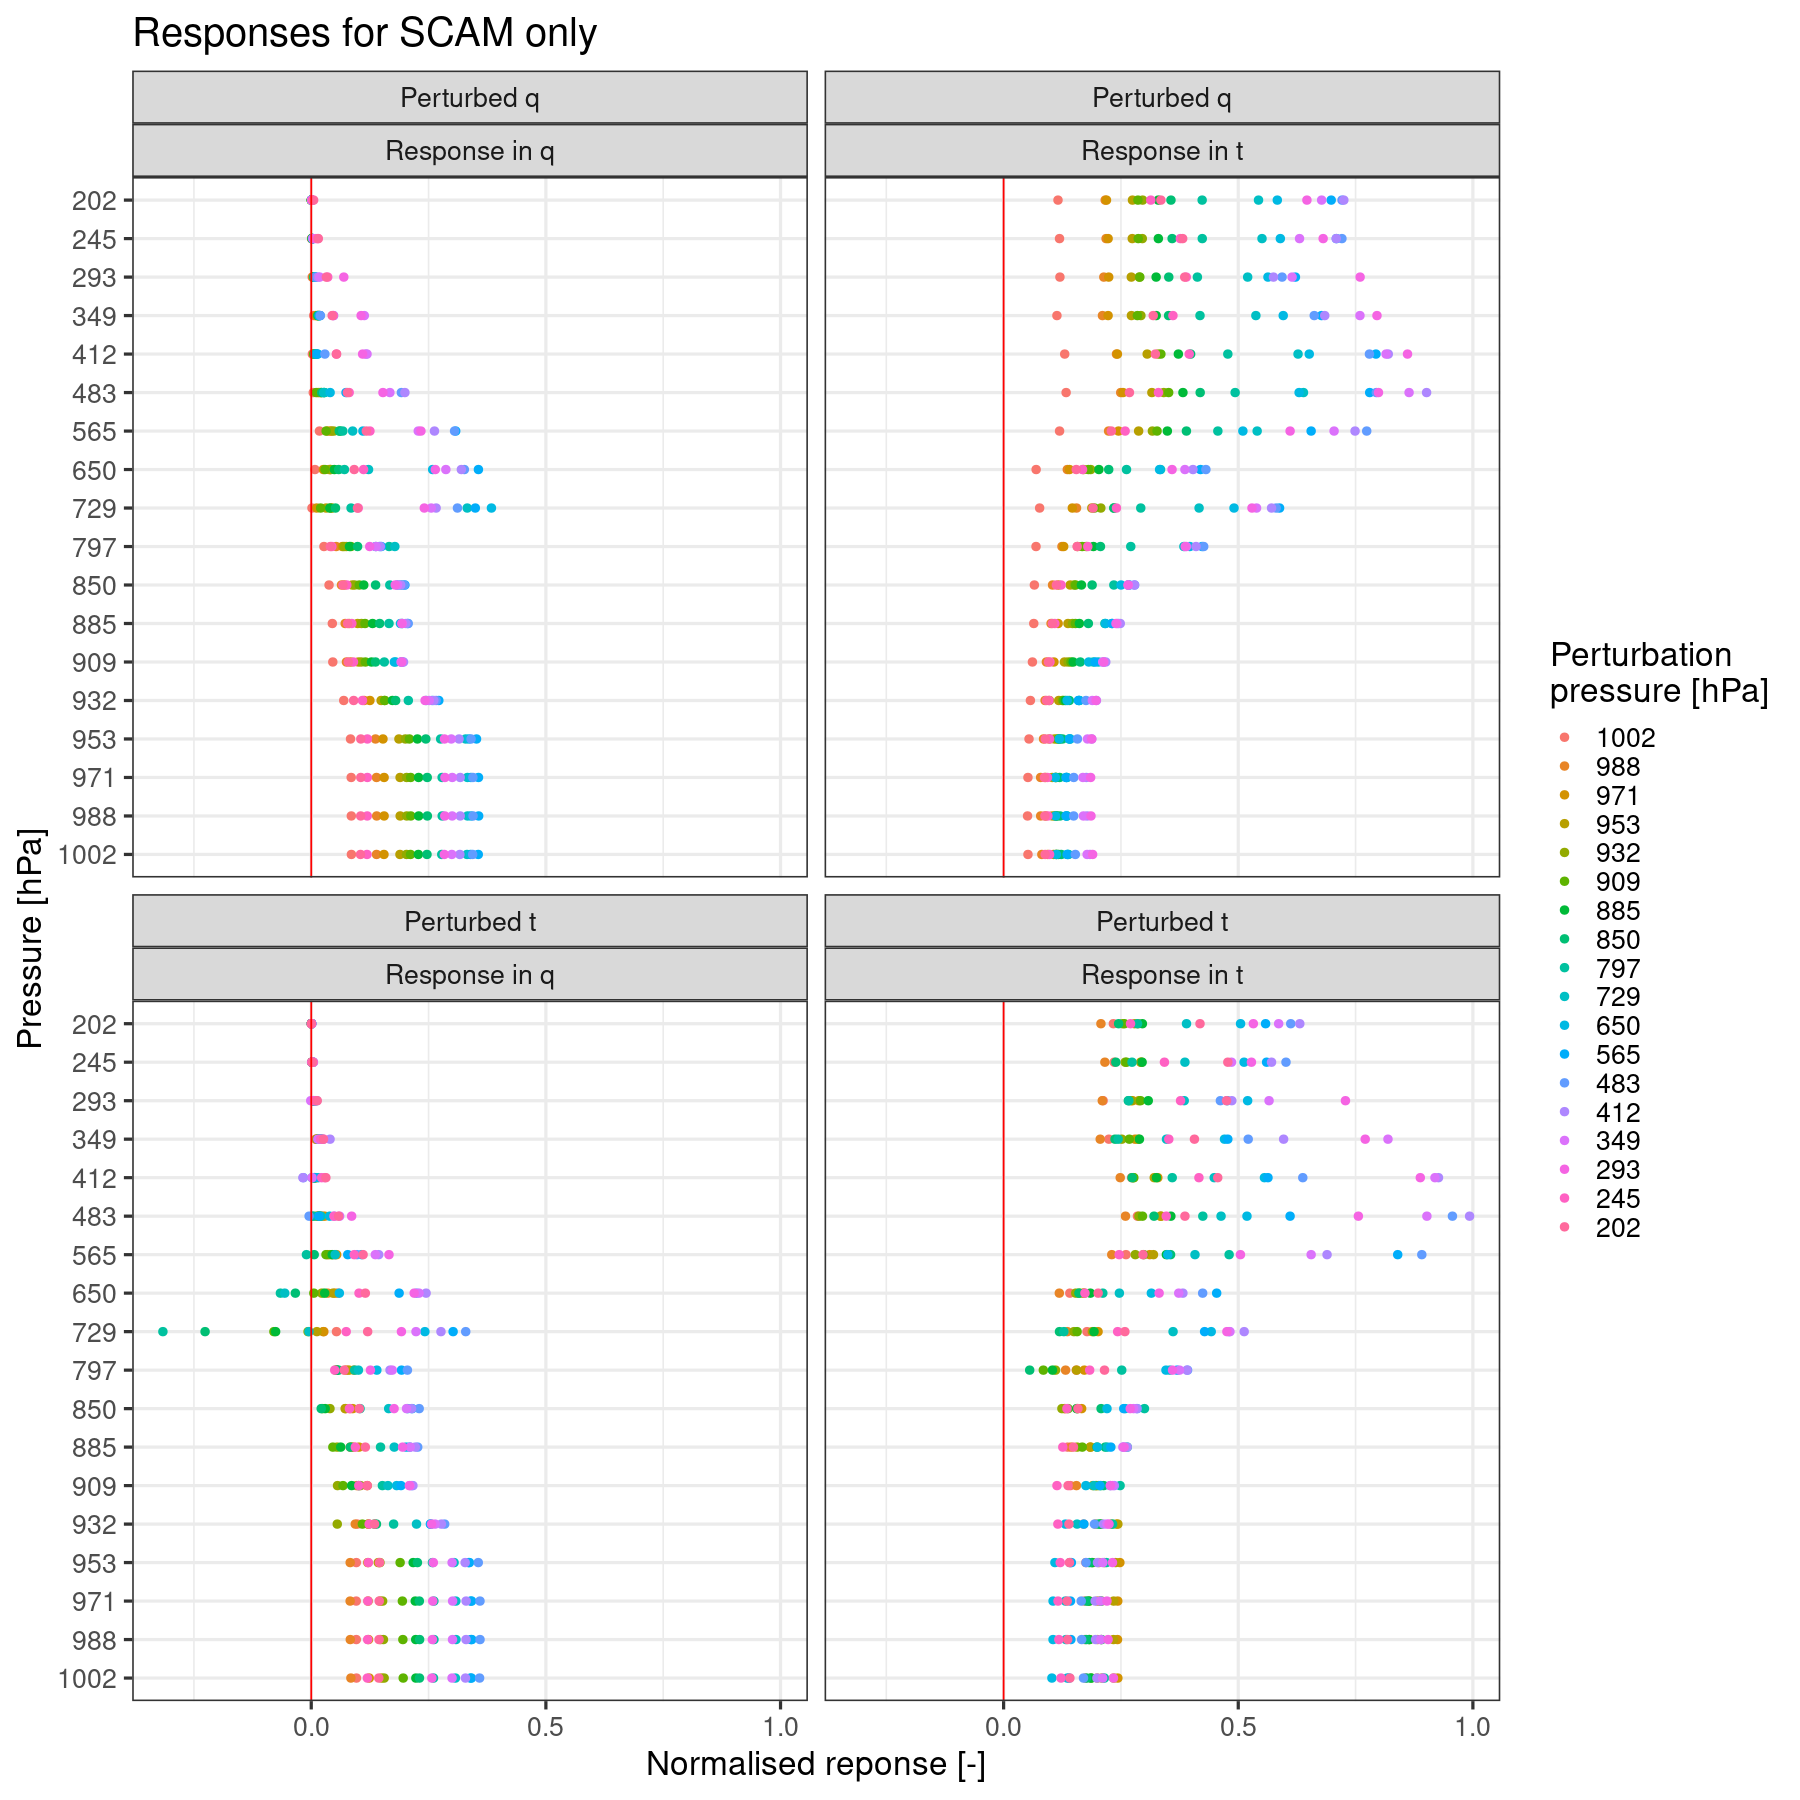

In [4]:
options(repr.plot.width=15, repr.plot.height=15) 
ggplot(responses[model == 'scam'], aes(x=response, y=response_pressure)) + 
geom_point(aes(colour=pert_pressure), size=2) +
facet_wrap(pert_variable~response_variable) + 
labs(x='Normalised reponse [-]', y='Pressure [hPa]', title='Responses for SCAM only') +
scale_colour_discrete(name="Perturbation\npressure [hPa]") +
geom_vline(xintercept=0, colour='red') +
theme_bw(textsize)

Here are the results for all models:

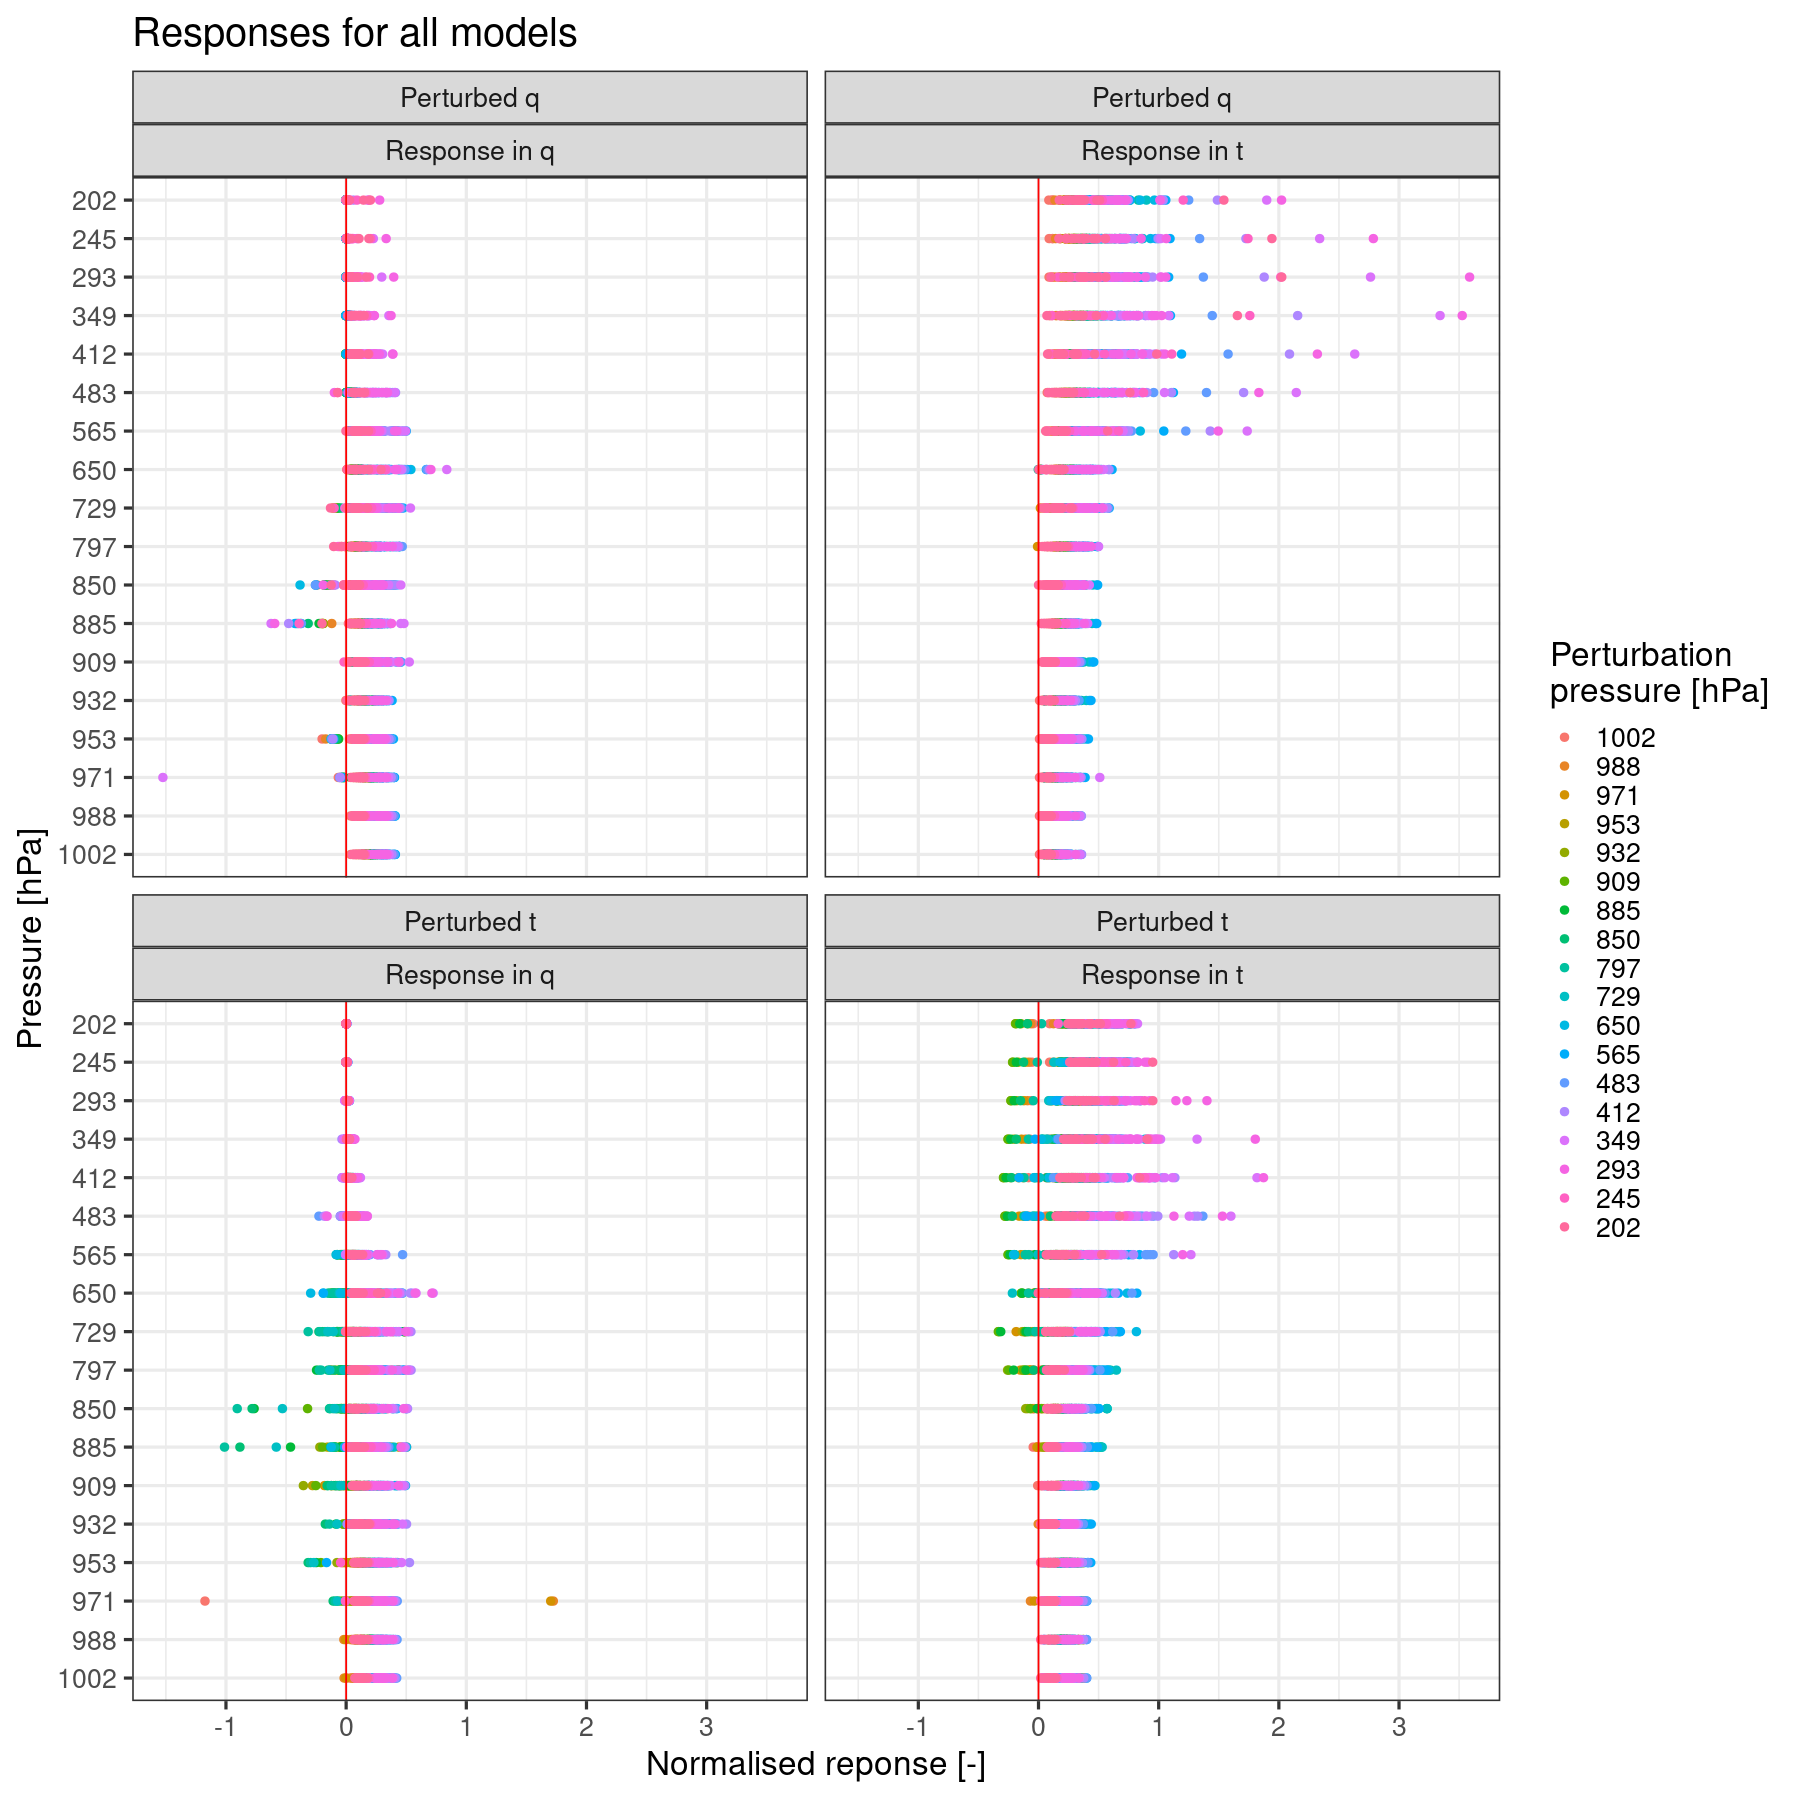

In [5]:
ggplot(responses, aes(x=response, y=response_pressure)) + 
geom_point(aes(colour=pert_pressure), size=2) +
facet_wrap(pert_variable~response_variable) + 
labs(x='Normalised reponse [-]', y='Pressure [hPa]', title='Responses for all models') +
scale_colour_discrete(name="Perturbation\npressure [hPa]") +
geom_vline(xintercept=0, colour='red') +
theme_bw(textsize)

## Tests of perturbation level combinations

Here I ask the question: *Which two perturbation level responses, when combined linearly, can best explain responses from all perturbation levels combined?*

Let $r(p_n, p_r)$ be a response at pressure level $r$, given a perturbation at pressure level $n$. Then the model I am fitting is

$$
r(p_x, p_r) = c_0 + c_1 r(p_1, p_r) + c_2 r(p_2, p_r)\quad\quad \forall x, r
$$

I test for all combinations of $p_1$ and $p_2$, for all data and for subsets of the data by perturbed and response variable. The "best" combination of $p_1$ and $p_2$ is the one for which the fitted model provides the highest $r^2$ value.

**Notes**
- I test both $r^2$ and 'adjusted $r^2$'; they are almost the same and provide the same optimal combinations.
- To do the test I construct a `data.table` containing for each response pressure and model `response_p1, response_p2, response` and I leave the responses from perturbing at $p_1$ and $p_2$ in the overall list of responses, meaning that the model is trained on all responses and not a subset with $p_1$ and $p_2$ removed.

In [6]:
res = NULL

# Function to fit the linear model and return r2 values.
lm_fit = function(dat) {
    fit = lm(response~response_p1+response_p2, data=dat)
    return(data.table(r2=summary(fit)$r.squared, r2_adj=summary(fit)$adj.r.squared))
}

# Function to test a particular combination of perturbation pressures p1 and p2.
test_pert_pressures_triplet = function(dat, p1, p2) { 
    cols = c("model", "response_variable", "pert_variable", "response_pressure")
    if(p1 == p2 | p1 > p2)
        return(NULL)
    
    # Subset for p1 and p2 perturbation pressures and combine into one data.table.
    subset_p1 = dat[pert_pressure == p1]
    subset_p2 = dat[pert_pressure == p2]
    setnames(subset_p1, "response", "response_p1")
    setnames(subset_p2, "response", "response_p2")
    subset_p1[, pert_pressure := NULL]
    subset_p2[, pert_pressure := NULL]
    setkeyv(subset_p1, cols)
    setkeyv(subset_p2, cols)
    subset = subset_p1[subset_p2]

    # Add response_p1 and response_p2 as columns to all the input data.
    setkeyv(dat, cols)
    set = dat[subset]
    
    # Fit to all data.
    fit_to_all = cbind(data.table(response_variable='All data', pert_variable='All data'), lm_fit(set))
    
    # Fit per response and perturbation variable (combinations of q and t).
    fit_by_resp = set[, lm_fit(.SD), by=c('response_variable', 'pert_variable')]
    res = cbind(data.table(p1=p1, p2=p2), rbind(fit_to_all, fit_by_resp))
    return(res)
}

test_fits = function(dat, test_func=test_pert_pressures_triplet) {
    # Test the fit for each combination of two perturbation pressure levels.
    p_comb_results = NULL
    for(p1 in pressures) {
        for(p2 in pressures) {       
            p_comb_results = rbind(p_comb_results, test_func(dat, p1=p1, p2=p2))
        }
    }      
    p_comb_results[, p1 := factor(p1, levels=pressures)]
    p_comb_results[, p2 := factor(p2, levels=pressures)]

    # Determine best pressure level combination; the one with highest r2 value.
    best_pressures = p_comb_results[, .SD[r2 == max(r2)], by=c('response_variable', 'pert_variable')]
    best_pressures_adj = p_comb_results[, .SD[r2_adj == max(r2_adj)], by=c('response_variable', 'pert_variable')]
    stopifnot(best_pressures == best_pressures_adj)
    
    return(list(p_comb_results=p_comb_results, best_pressures=best_pressures))
}

In [7]:
all_data_results = test_fits(responses)
p_comb_results = all_data_results$p_comb_results
best_pressures = all_data_results$best_pressures
best_pressures[, set := 'Best r2']

In [17]:
p1 = 850
p2 = 650
dat = responses


cols = c("model", "response_variable", "pert_variable", "response_pressure")
    
# Subset for p1 and p2 perturbation pressures and combine into one data.table.
subset_p1 = dat[pert_pressure == p1]
subset_p2 = dat[pert_pressure == p2]
setnames(subset_p1, "response", "response_p1")
setnames(subset_p2, "response", "response_p2")
subset_p1[, pert_pressure := NULL]
subset_p2[, pert_pressure := NULL]
setkeyv(subset_p1, cols)
setkeyv(subset_p2, cols)
subset = subset_p1[subset_p2]

# Add response_p1 and response_p2 as columns to all the input data.
setkeyv(dat, cols)
set = dat[subset]
    
    # Fit to all data.
#    fit_to_all = cbind(data.table(response_variable='All data', pert_variable='All data'), lm_fit(set))
    
#    # Fit per response and perturbation variable (combinations of q and t).
#    fit_by_resp = set[, lm_fit(.SD), by=c('response_variable', 'pert_variable')]
#    res = cbind(data.table(p1=p1, p2=p2), rbind(fit_to_all, fit_by_resp))
#    return(res)

set[, length(response), by=c('response_variable','pert_variable')]

response_variable,pert_variable,V1
<chr>,<chr>,<int>
Response in q,Perturbed q,4212
Response in q,Perturbed t,4212
Response in t,Perturbed q,4212
Response in t,Perturbed t,4212


Add `marked_pressures` which are comparison points to display on the plot of $r^2$ results.

In [8]:
marked_pressures = copy(best_pressures)
marked_pressures = marked_pressures[, r2 := NULL]
marked_pressures = marked_pressures[, r2_adj := NULL]

hk = copy(marked_pressures)
yl = copy(marked_pressures)

hk[, set := 'Herman and Kuang 2013']
hk[, p1 := factor(729, levels=pressures)]
hk[, p2 := factor(850, levels=pressures)]

yl[, set := 'Yi-Ling']
yl[, p1 := factor(650, levels=pressures)]
yl[, p2 := factor(850, levels=pressures)]

marked_pressures = rbind(marked_pressures, hk, yl)

## Results

Here's a plot of the resulting $r^2$ values per combination of perturbation pressure levels and for all data. The combination with the highest value of $r^2$ is marked with a red dot.

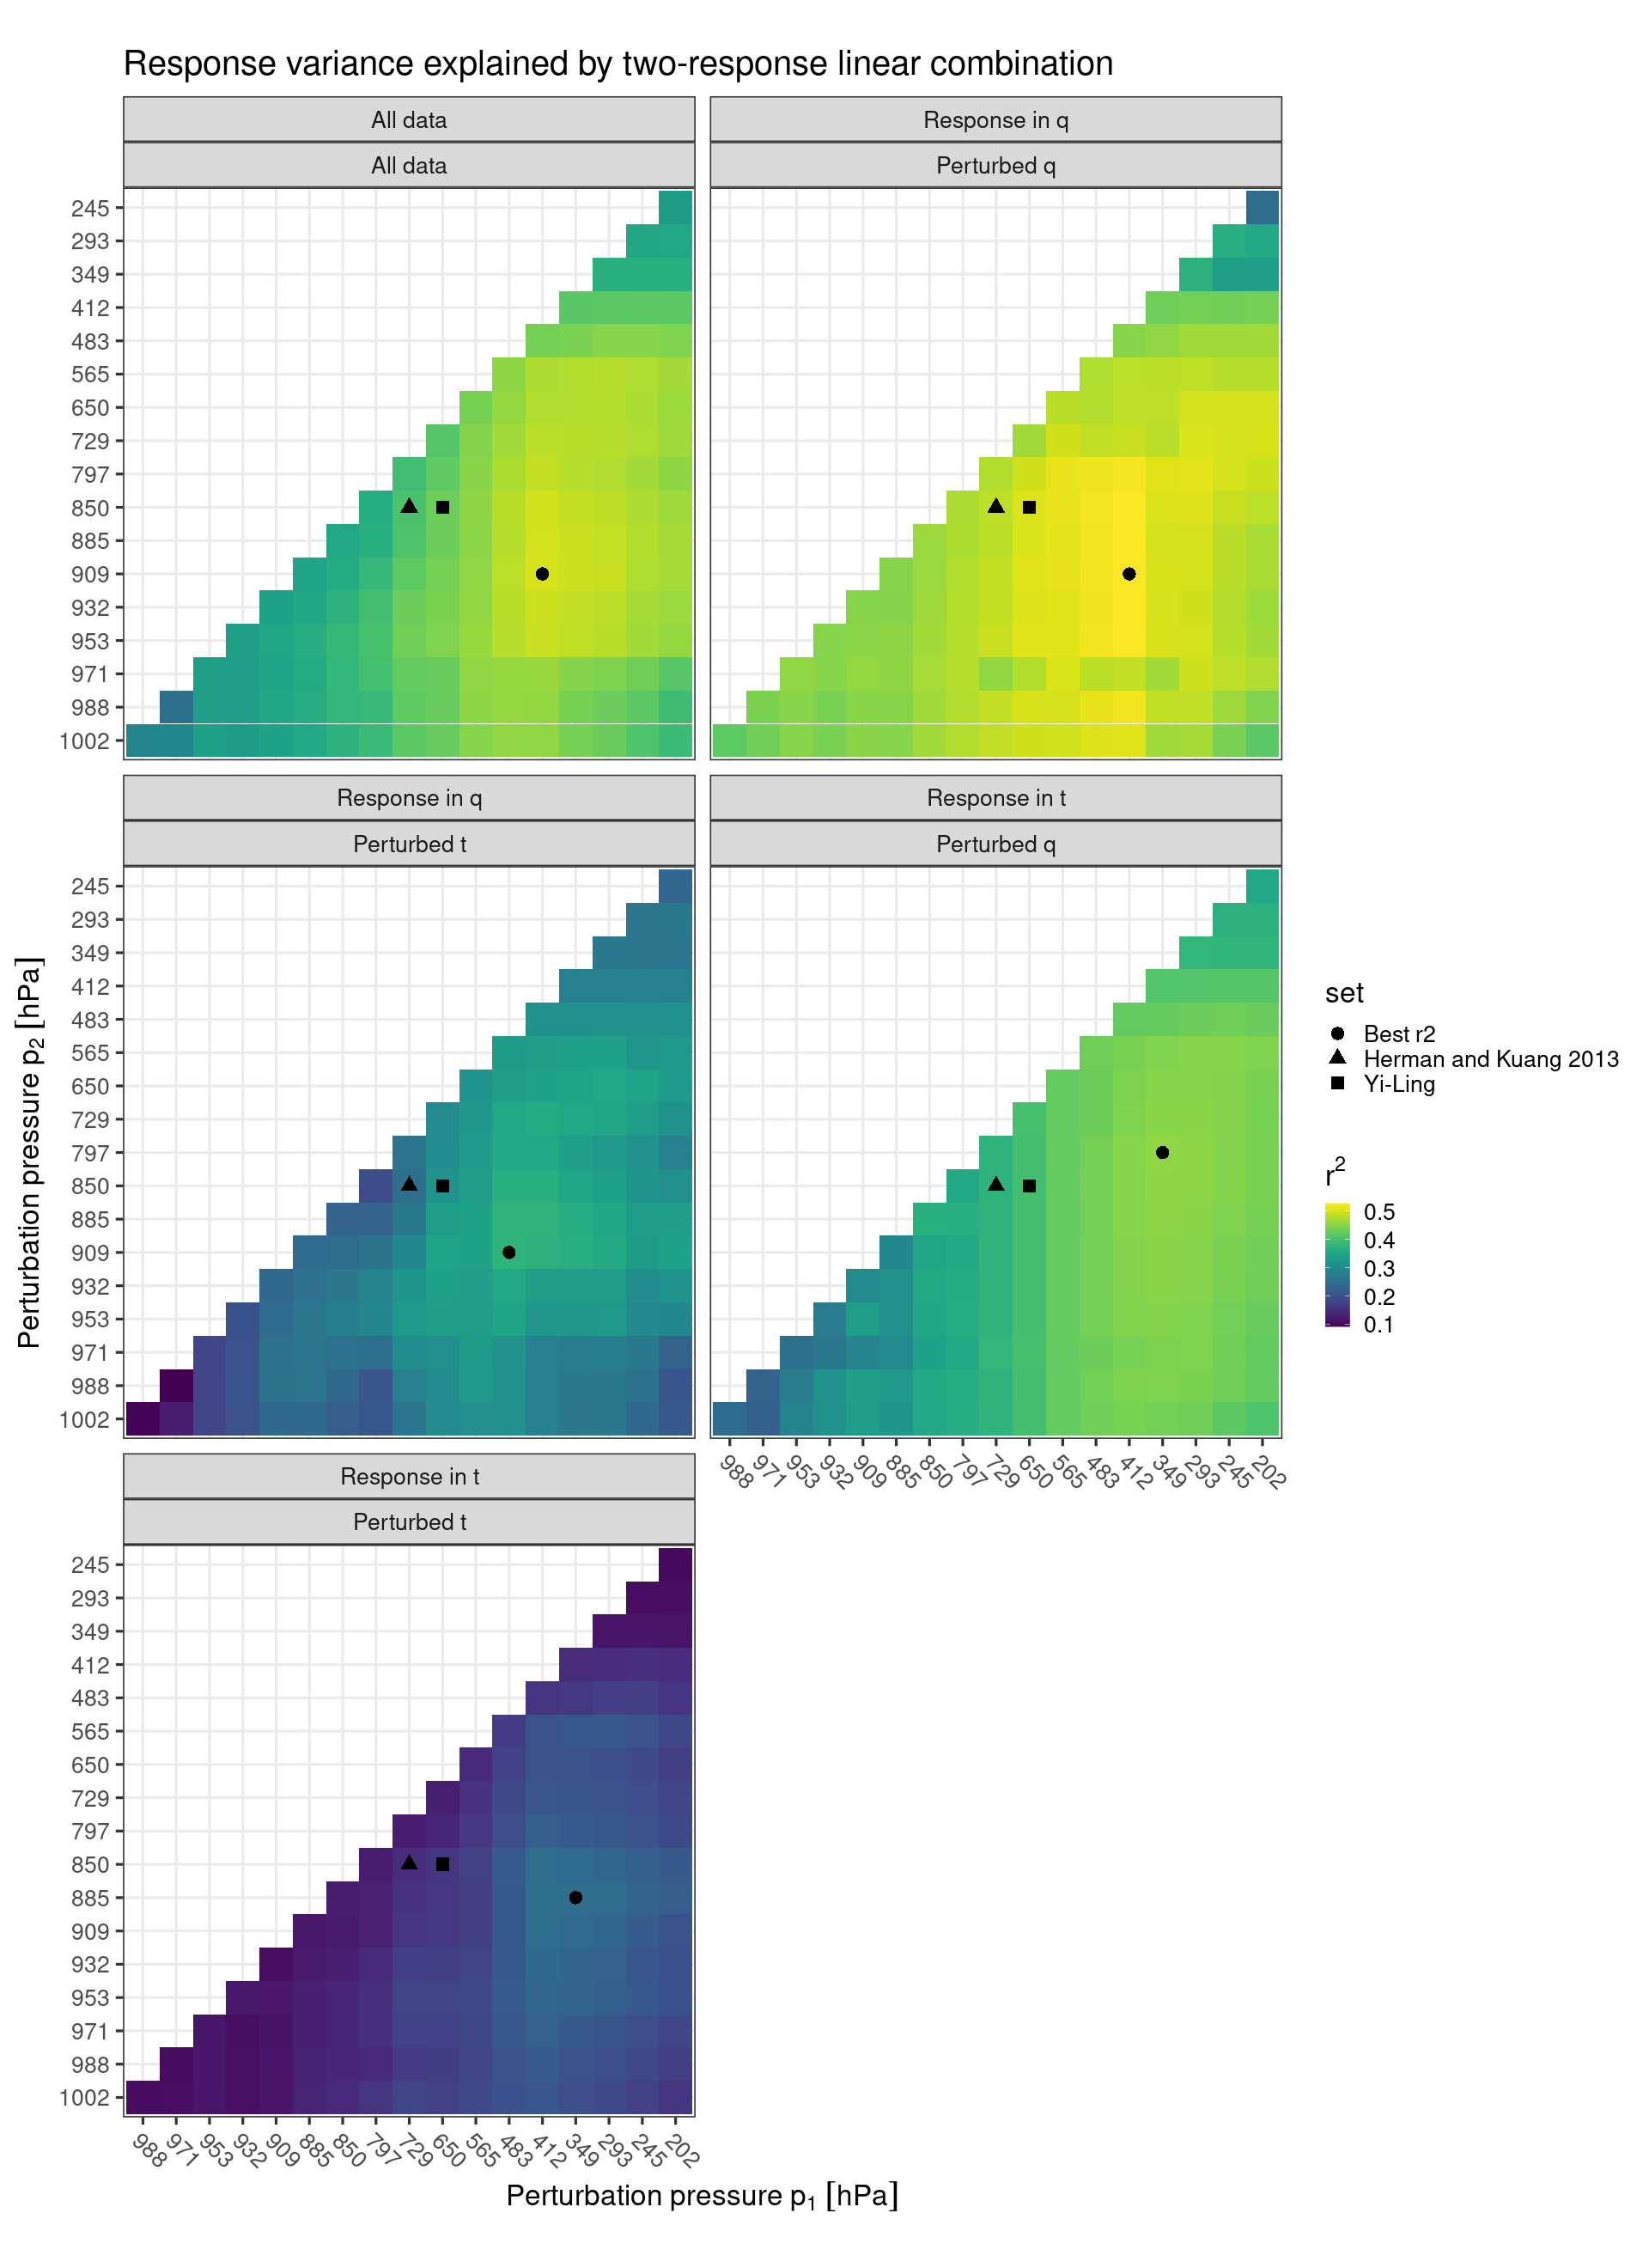

In [9]:
options(repr.plot.width=16, repr.plot.height=22) 
ggplot(p_comb_results, aes(x=p1, y=p2)) + 
geom_tile(aes(fill=r2)) +
scale_fill_viridis(name=parse(text='r^2')) +
theme_bw(textsize) + 
theme(axis.text.x = element_text(angle=-45, hjust=0, vjust=1)) +
geom_point(data=marked_pressures, colour='black', aes(shape=set), size=4) +
labs(x=parse(text="Perturbation~pressure~p[1]~group('[', hPa, ']')"), 
     y=parse(text="Perturbation~pressure~p[2]~group('[', hPa, ']')"),
     title='Response variance explained by two-response linear combination') +
facet_wrap(response_variable~pert_variable, ncol=2) +
coord_equal()

The best pressures for each combination are as follows:

In [10]:
print(best_pressures)

   response_variable pert_variable  p1  p2        r2    r2_adj     set
1:          All data      All data 412 909 0.5000686 0.5000093 Best r2
2:     Response in q   Perturbed q 412 909 0.5270691 0.5268444 Best r2
3:     Response in q   Perturbed t 483 909 0.3753485 0.3750517 Best r2
4:     Response in t   Perturbed q 349 797 0.4545860 0.4543269 Best r2
5:     Response in t   Perturbed t 349 885 0.2482395 0.2478823 Best r2


Given these results a choice of 412 hPa and 885 hPa seems reasonable. The linear fit results for this combination are:

In [11]:
chosen_p = c(412, 885)
selected_results = p_comb_results[p1 == chosen_p[1] & p2 == chosen_p[2]]
print(selected_results)

    p1  p2 response_variable pert_variable        r2    r2_adj
1: 412 885          All data      All data 0.4982762 0.4982166
2: 412 885     Response in q   Perturbed q 0.5264148 0.5261897
3: 412 885     Response in q   Perturbed t 0.3737536 0.3734560
4: 412 885     Response in t   Perturbed q 0.4473590 0.4470964
5: 412 885     Response in t   Perturbed t 0.2478420 0.2474846


And the difference between the "best" results for each response/perturbation variable combination and the results for this overall optimal chosen combination of pressure levels is small:

In [12]:
compare_to_best = function(chosen_p) {
    selected_results = p_comb_results[p1 == chosen_p[1] & p2 == chosen_p[2]]
    setkey(selected_results, response_variable, pert_variable)
    setkey(best_pressures, response_variable, pert_variable)
    print(selected_results[best_pressures, list(response_variable, pert_variable, r2_diff=r2-i.r2)])
}

compare_to_best(chosen_p)

   response_variable pert_variable       r2_diff
1:          All data      All data -0.0017924117
2:     Response in q   Perturbed q -0.0006543648
3:     Response in q   Perturbed t -0.0015949419
4:     Response in t   Perturbed q -0.0072270769
5:     Response in t   Perturbed t -0.0003974869


Here are the differences between the best $r^2$ perturbation levels and those used by Herman and Kuang 2013 (730 and 850 hPa, here 729 and 850 hPa):

In [13]:
compare_to_best(c(729, 850))

   response_variable pert_variable     r2_diff
1:          All data      All data -0.09834457
2:     Response in q   Perturbed q -0.04330938
3:     Response in q   Perturbed t -0.12742653
4:     Response in t   Perturbed q -0.08101826
5:     Response in t   Perturbed t -0.10132547


And here are differences between the best $r^2$ perturbation levels and those used by Yi-Ling (850 and 650 hPa):

In [14]:
compare_to_best(c(650, 850))

   response_variable pert_variable     r2_diff
1:          All data      All data -0.06976125
2:     Response in q   Perturbed q -0.02275746
3:     Response in q   Perturbed t -0.05918764
4:     Response in t   Perturbed q -0.05828976
5:     Response in t   Perturbed t -0.08914220


Here are the responses for the perturbation levels deemed overall the most explanatory:

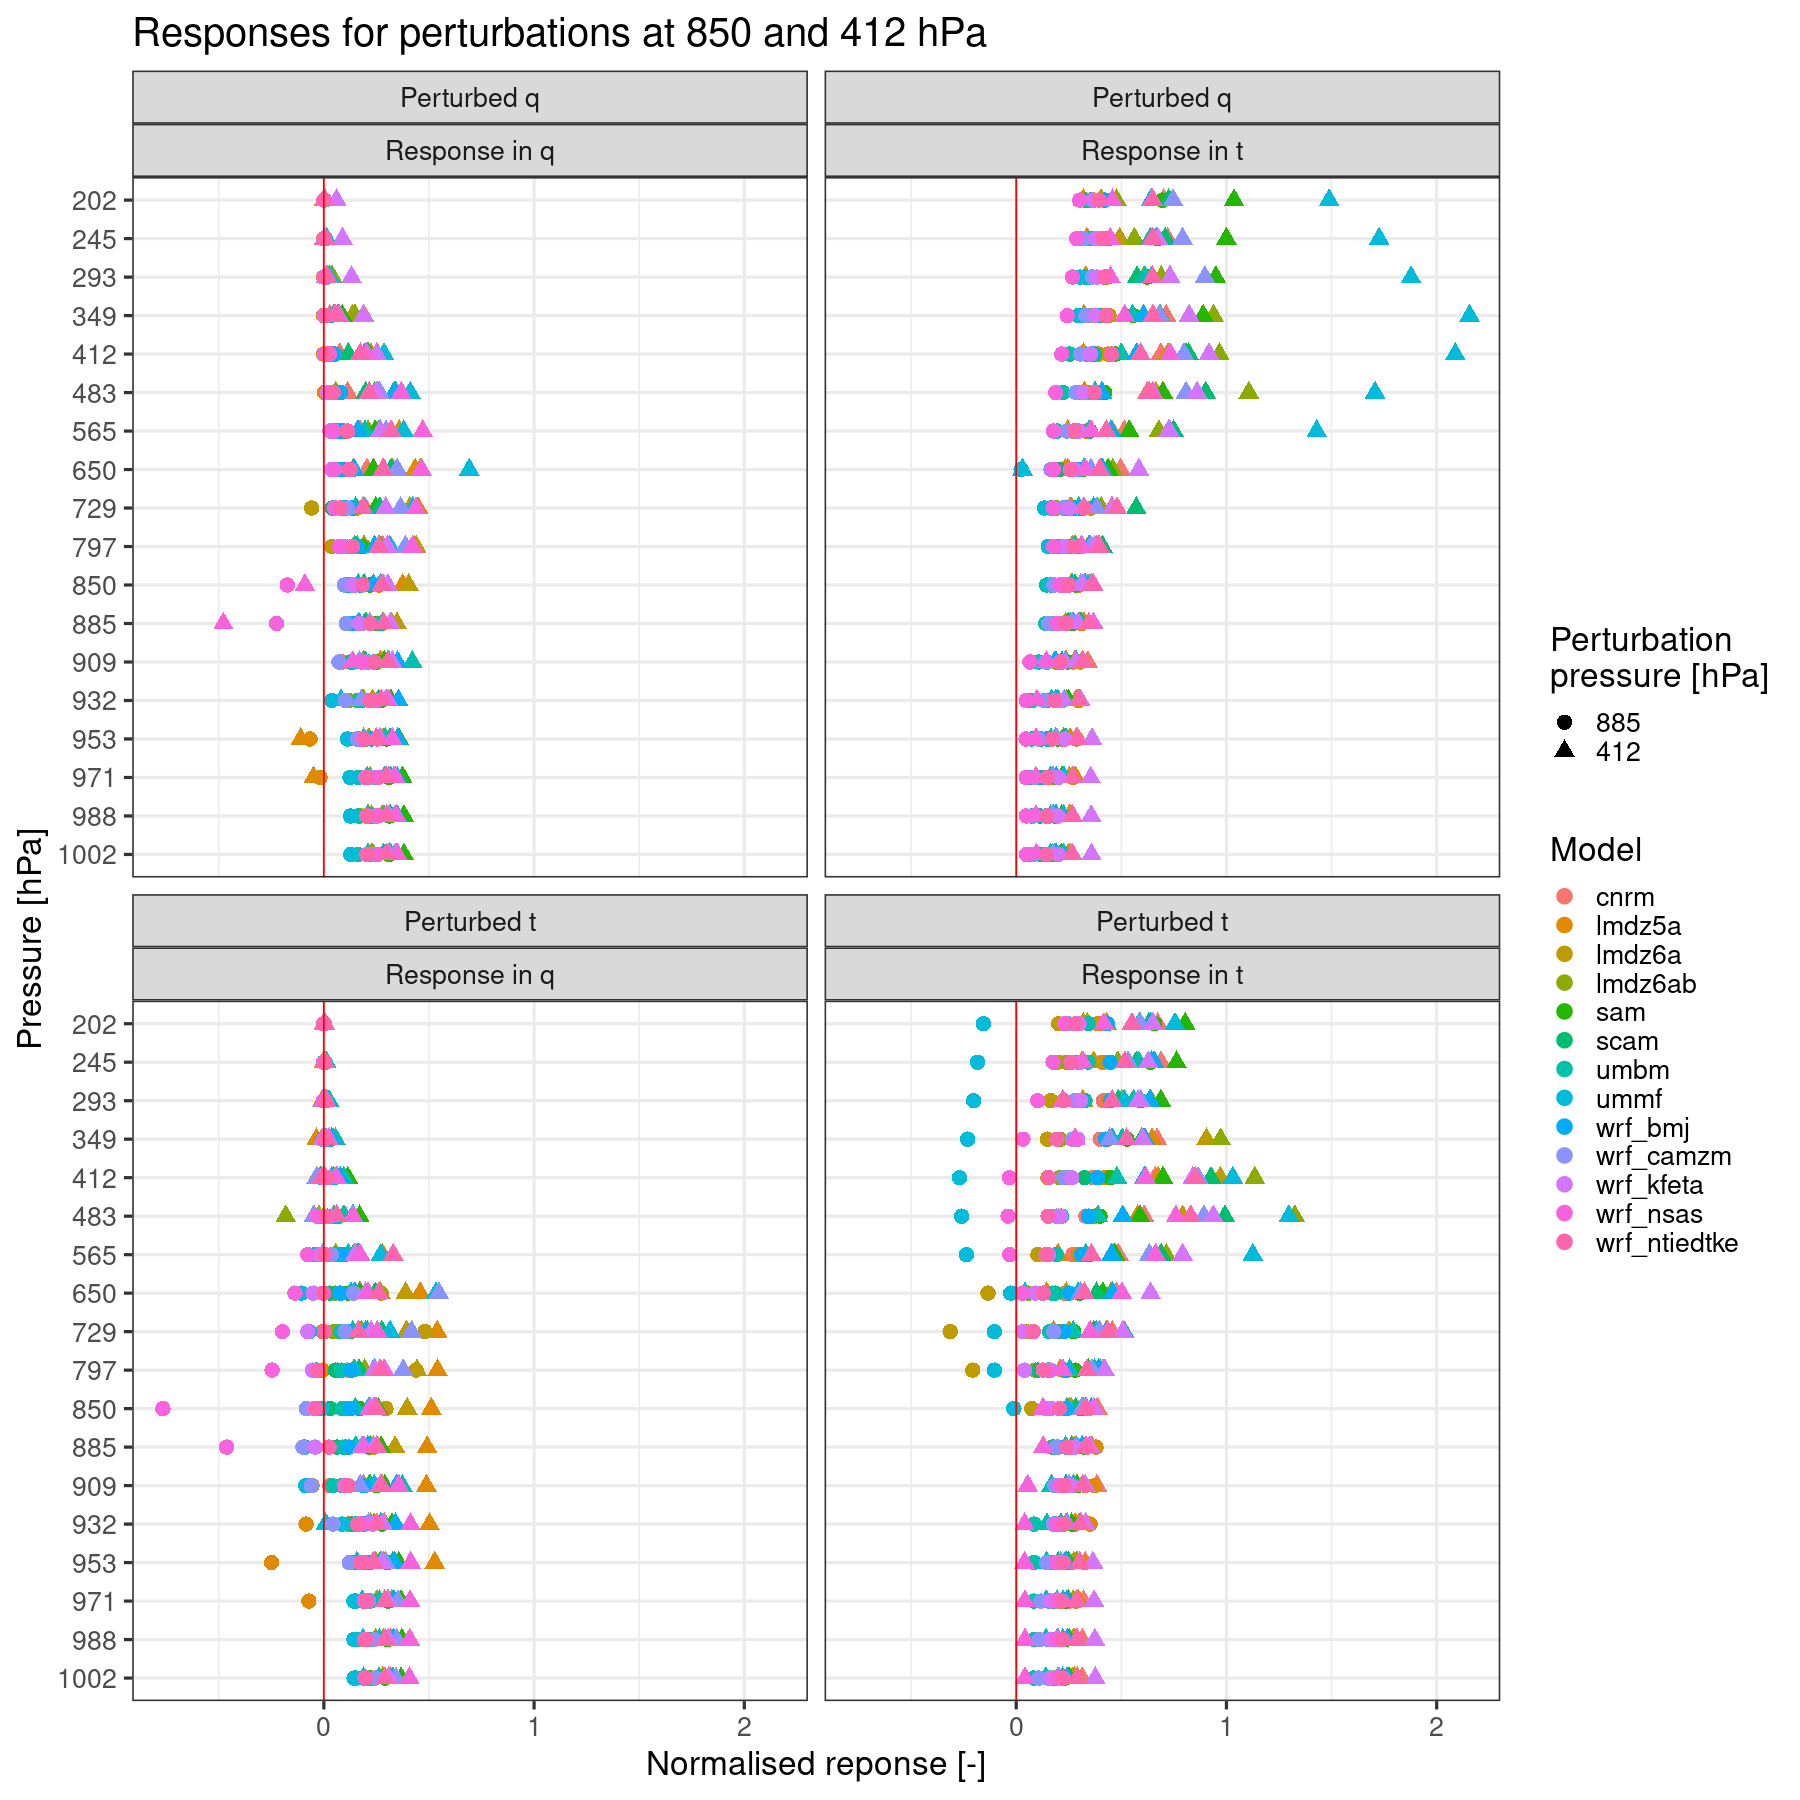

In [15]:
options(repr.plot.width=15, repr.plot.height=15)
ggplot(responses[pert_pressure %in% chosen_p], aes(x=response, y=response_pressure)) + 
geom_point(aes(colour=model, shape=pert_pressure), size=4) +
facet_wrap(pert_variable~response_variable) + 
labs(x='Normalised reponse [-]', y='Pressure [hPa]', title='Responses for perturbations at 850 and 412 hPa') +
scale_colour_discrete(name='Model') + 
scale_shape_discrete(name="Perturbation\npressure [hPa]") +
geom_vline(xintercept=0, colour='red') +
theme_bw(textsize)

## Results with outlier models removed

There are two models that have large outliers -- UM-MF has outlier responses for temperature and WRF NSAS for specific humidity. Removing these two models and repeating the analysis:

In [16]:
subset_data_results = test_fits(dat=responses[!(model %in% c('ummf', 'wrf_nsas'))])
p_comb_results_subset = subset_data_results$p_comb_results
best_pressures_subset = subset_data_results$best_pressures

In [17]:
print(best_pressures_subset)

   response_variable pert_variable  p1  p2        r2    r2_adj
1:          All data      All data 412 885 0.5760720 0.5760125
2:     Response in q   Perturbed q 412 932 0.5146935 0.5144209
3:     Response in q   Perturbed t 412 850 0.4151964 0.4148679
4:     Response in t   Perturbed q 349 797 0.5307157 0.5304521
5:     Response in t   Perturbed t 349 885 0.3361578 0.3357849


In [18]:
print(best_pressures)

   response_variable pert_variable  p1  p2        r2    r2_adj     set
1:          All data      All data 412 909 0.5000686 0.5000093 Best r2
2:     Response in q   Perturbed q 412 909 0.5270691 0.5268444 Best r2
3:     Response in q   Perturbed t 483 909 0.3753485 0.3750517 Best r2
4:     Response in t   Perturbed q 349 797 0.4545860 0.4543269 Best r2
5:     Response in t   Perturbed t 349 885 0.2482395 0.2478823 Best r2
